#### CITS5508 Assignment 3
* _File          : assignment3.ipynb_
* _Contact       : 22056151@student.uwa.edu.au_
* _Author        : Suning (Juliet) Li_
<br><br>
* _Editor        : Visual Studio Code 1.77.0_
* _Python Version: 3.10.6_
* _Version       : 1.0_
<br><br>
* _License       : (C)Copyright Juliet_Li_2023_
* _Description   : This is the python notebook for CITS5508 assignment 3._
* _ModifyTime    : 10/05/2023_

<br> Please note a number of functions and code blocks in this notebook are leveraging assginment 1 and assignment 2.
<br> Please run this notebook top down without jumping sections.

# Section 1: A model for diagnosing cancer <br>

In [157]:
import pandas as pd

# Load the dataset
df_breast = pd.read_csv('breast-cancer.csv')

In [158]:
df_breast.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


### Task 1: Logistic regression and decision tree for tumour status prediction

##### Part 1: Investigation and Preparation of the data
* Change target value to numeric
* Check for missing values
* Check for feature correlation, remove highly correlated features
* Check separation of feature space
* Check distribution and balance of the feature space
* split the training and testing data
* feature scaling

In [159]:
# As the target value is text, we will convert it to numbers first
from sklearn.preprocessing import LabelEncoder

# Encode the diagnosis variable
le = LabelEncoder()
df_breast['diagnosis_text'] = df_breast['diagnosis']
df_breast['diagnosis'] = le.fit_transform(df_breast['diagnosis'])

# Get the list of classes by the encoder
classes = le.classes_
mapping = {label: integer for integer, label in enumerate(classes)}

print(mapping)

{'B': 0, 'M': 1}


In [162]:
# To see the total number of missing values in the entire DataFrame
features_breast = df_breast.columns[2:-1]

total_missing_values = df_breast[features_breast].isna().sum().sum()
print(f"\nTotal missing values in DataFrame: {total_missing_values}")


Total missing values in DataFrame: 0


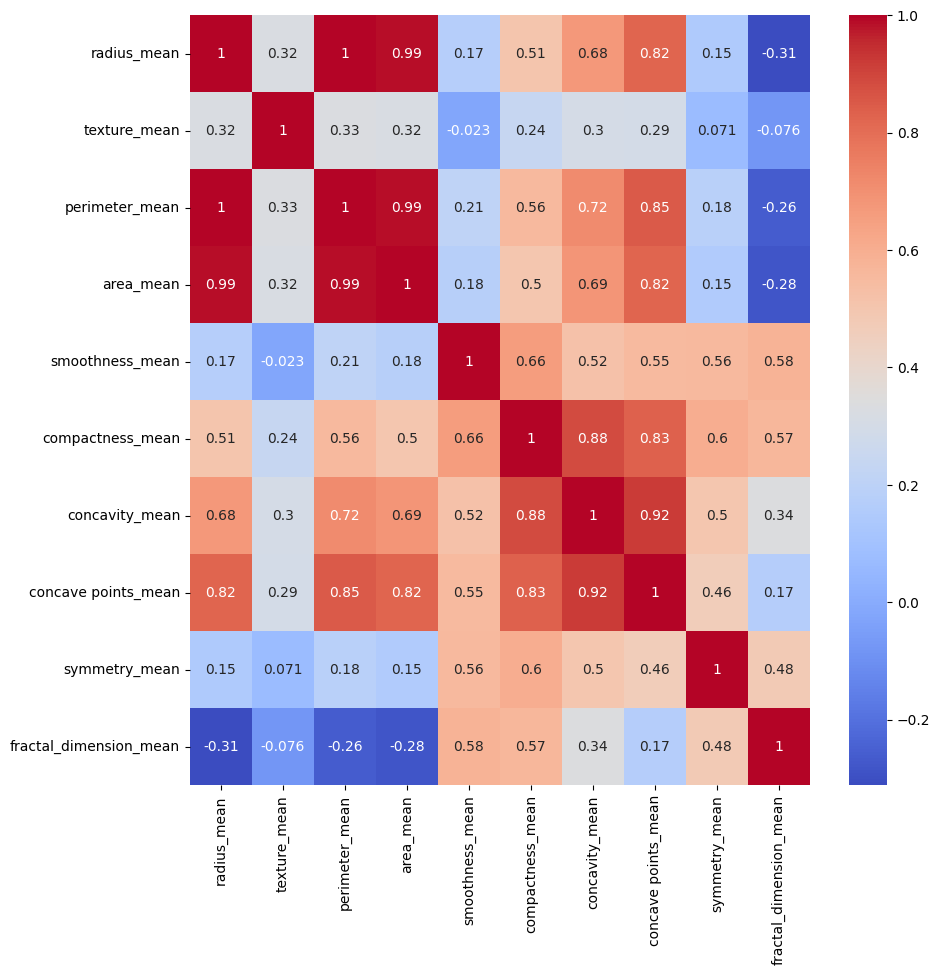

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting correlation heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(df_breast[features_breast].corr(), annot=True, cmap="coolwarm")
plt.show()

In reference to the plot above:
* A heat map of the correlation matrix between the 10 features is plotted.
* As can be seen, there are some features with above 0.9 correlation with each other. 
* radius_mean and perimeter_mean have the perfect correlation =1
* The features that are highly correlated need to be be dropped before training. 
* Reasons for why the correlated features need to be drop are explained in assignment 2, will not be explained again here. 
* The function wrote in assginment 2 will be used below to drop the correlated features. 

In [164]:
# define a function to drop highly correlated features
def drop_corr_features(correlation_threshold,correlation_matrix,df_feature):
    
    # Create a set for the features to be dropped
    features_to_drop = set()

    # Loop through the correlation matrix and identify the features that are highly correlated and are to be dropped
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) >= correlation_threshold:
                colname = correlation_matrix.columns[i]
                
                features_to_drop.add(colname)
                # #Print the highly correlated features 
                # print(colname, ',', correlation_matrix.index[j], ':', correlation_matrix.iloc[i, j])
    if len(features_to_drop) > 0:
        # Drop the features from the original dataframe
        df_feature_dropped = df_feature.drop(features_to_drop, axis=1)
    else:
        df_feature_dropped = df_feature

    # print the features that should be dropped as they are highly correlated with other features
    print(len(features_to_drop), 'features is dropped:',features_to_drop)

    return df_feature_dropped

In [165]:
# drop features that has higher correlation than 0.9 or lower than -0.9
df_feature_dropped = drop_corr_features(0.9,df_breast[features_breast].corr(),df_breast[features_breast])
features_dropped = df_feature_dropped.columns

3 features is dropped: {'concave points_mean', 'perimeter_mean', 'area_mean'}


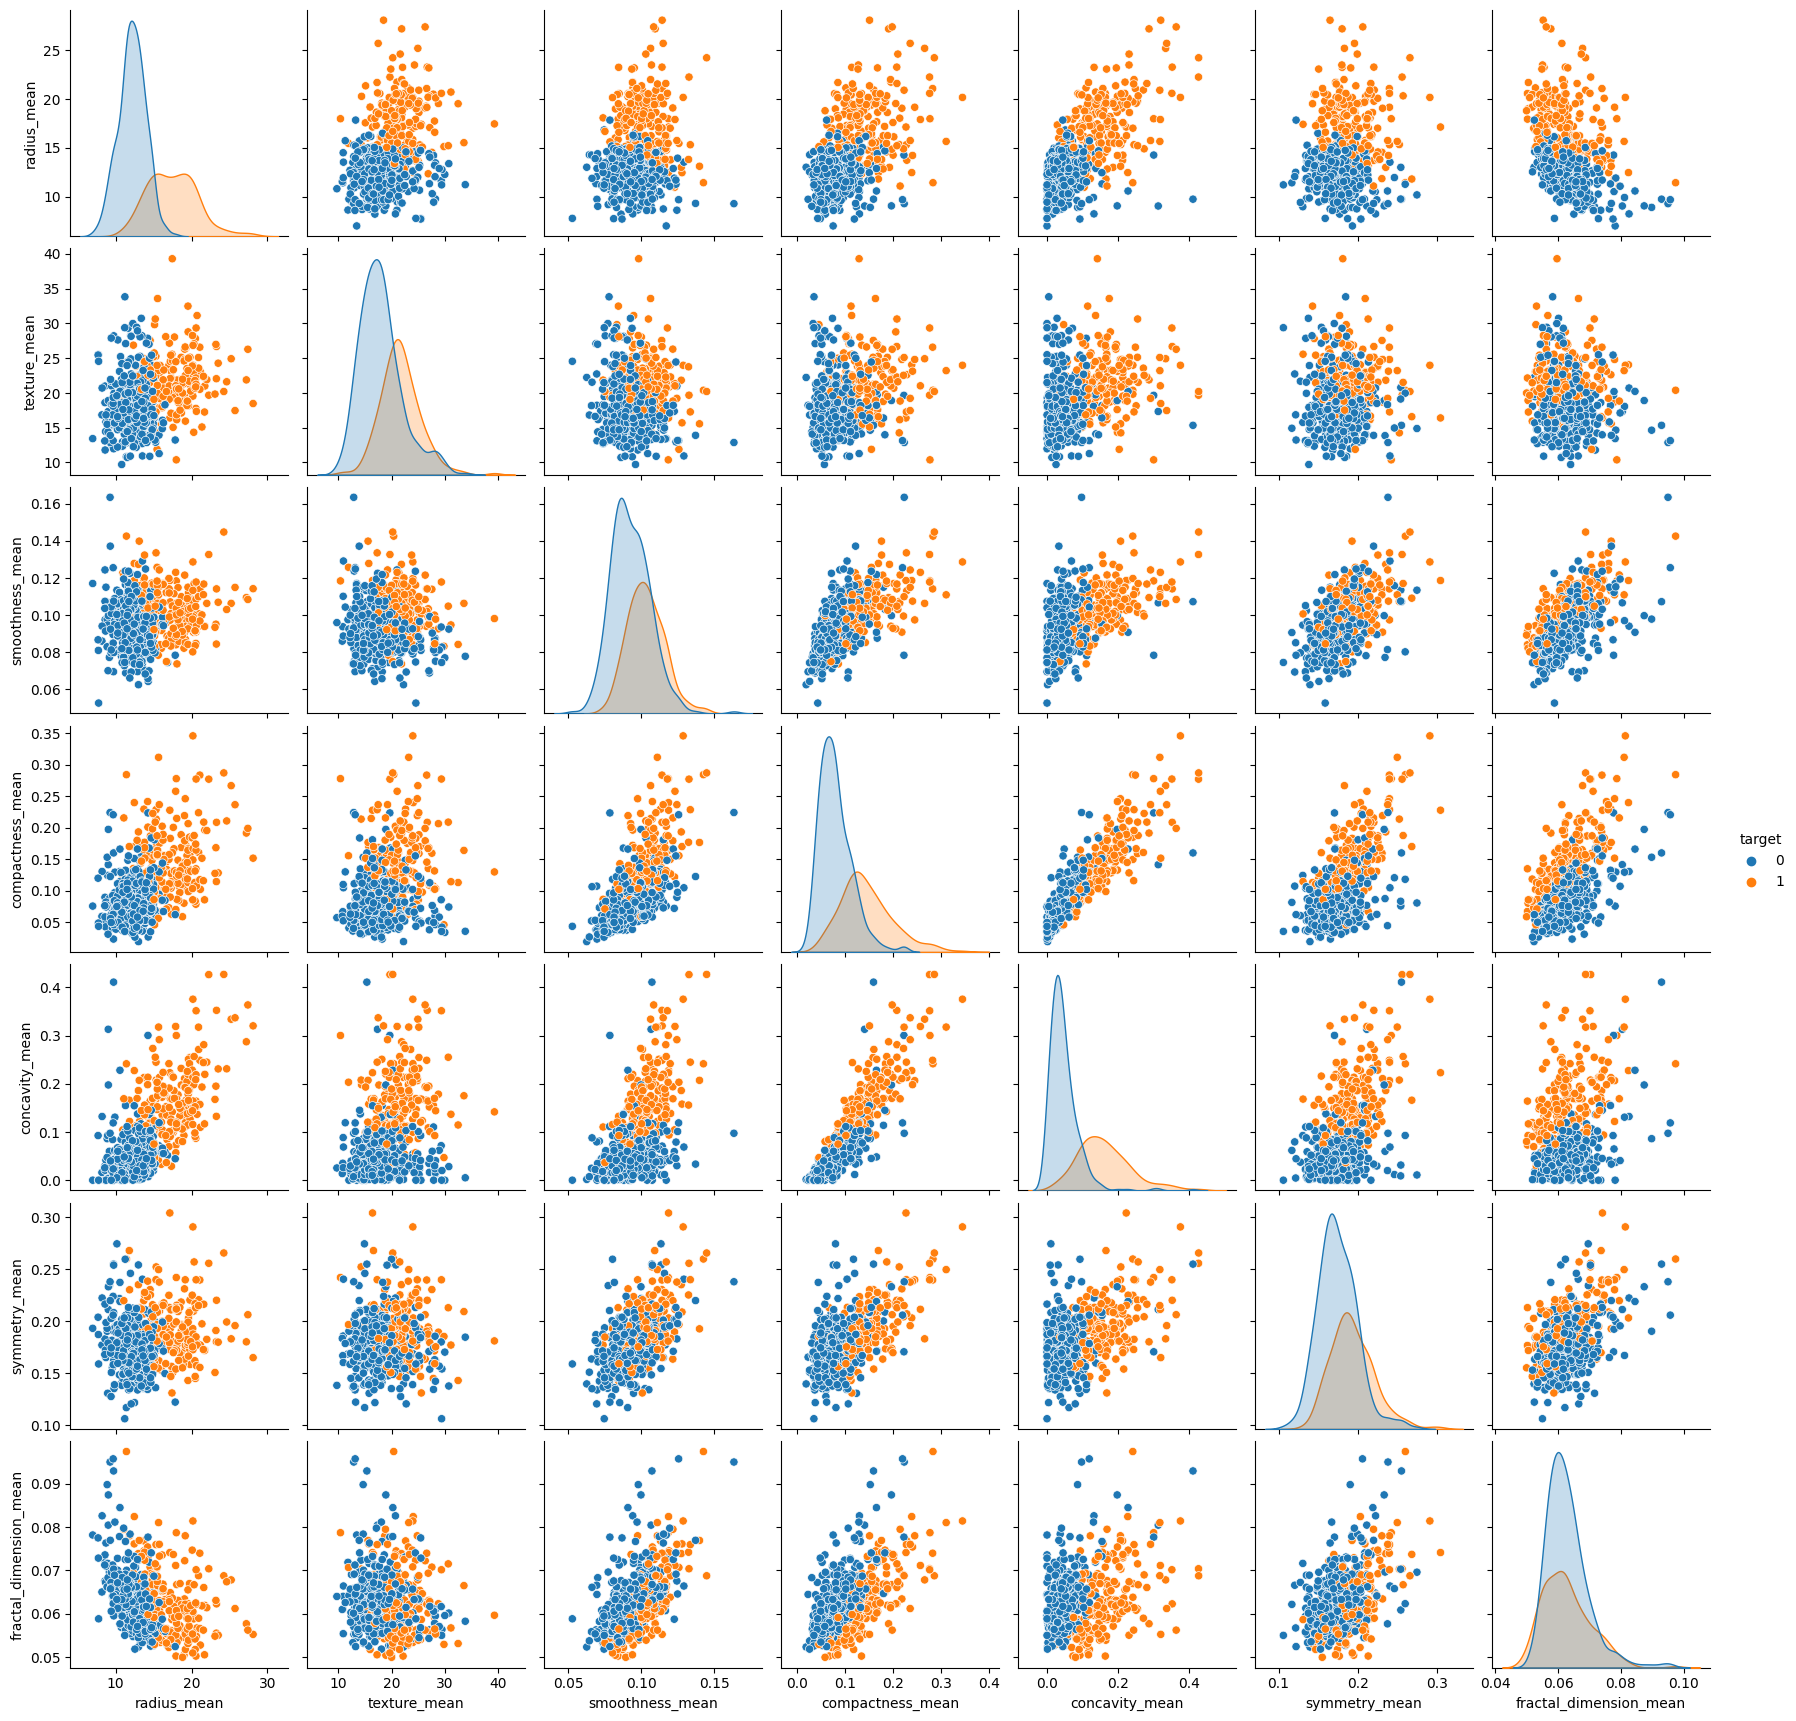

In [166]:
# Plotting the feature pairs, to see the separation of the feature space
df_feature_dropped['target'] = df_breast['diagnosis']

sns.pairplot(df_feature_dropped, vars=features_dropped, hue='target')
plt.show()

# As can be seen from below, the feature space is relatively separated.

In reference to the plot above;
* Each feature pair is plotted, and the scatter plot is coloured by the target label. 
* As can be seen, for most of the feature pairs, the target labels are relatively separated. 
* A relatively separated feature space will help the model getting better performance. 

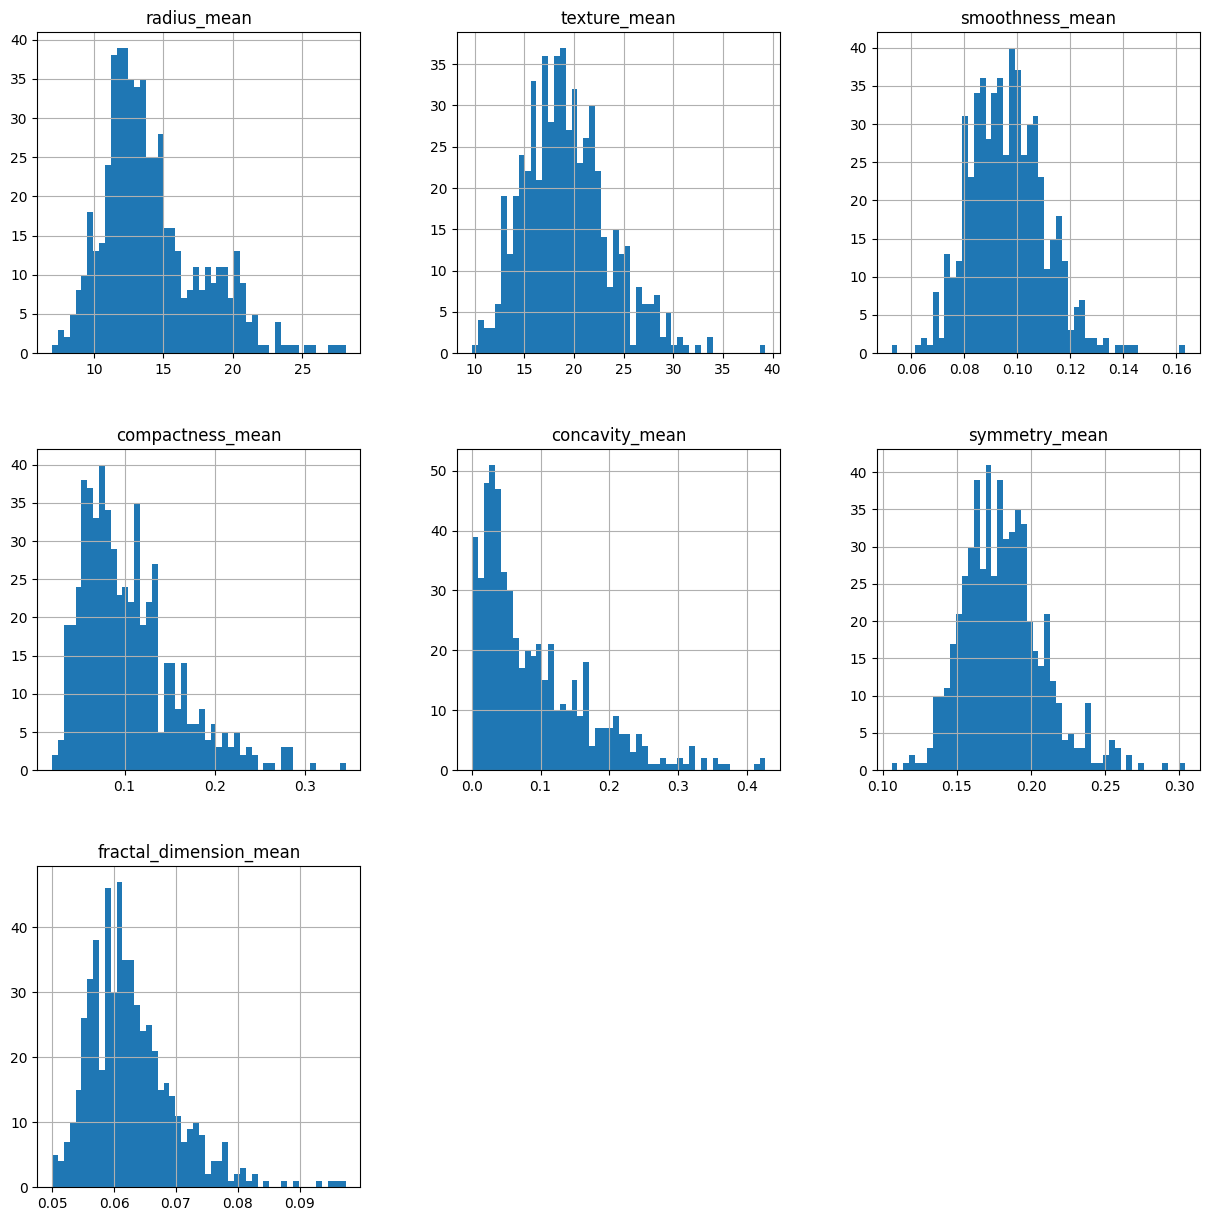

In [167]:
# plotting the distribution of each one of the features
df_feature_dropped[features_dropped].hist(bins=50, figsize=(15,15))
plt.show()

In referece to the above plot:
* The distribution of the 7 features (after dropped) are plotted. 
* Most of the features have a relatively balanced distribution amongst its maximum and minimum values. 
* The concavity feature is slightly right-skewed. 
* slightly right-skewed features may be affecting the model performance, especially the models that rely on presumption of a Gaussian distribution. Resampling techniques can be applied if needed. but we will not be going into this much detailed here. 
* Overall, the rest of the features are quite balanced. 

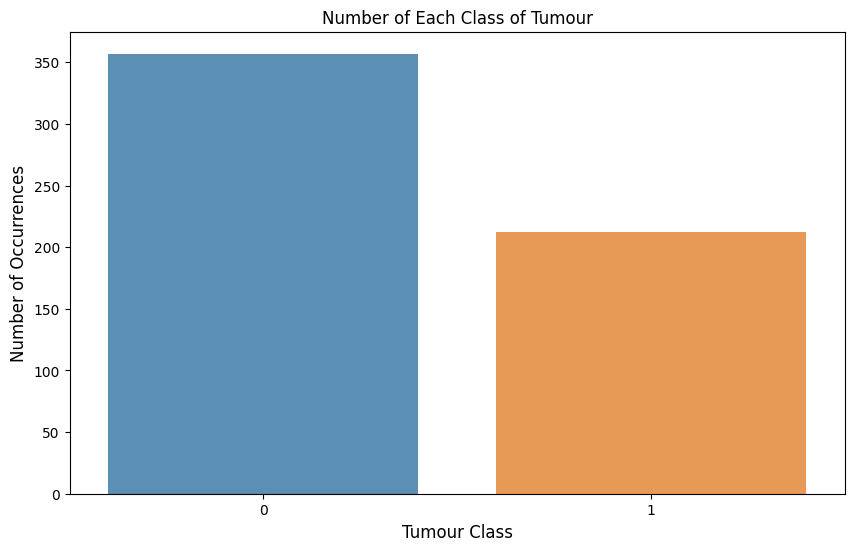

In [168]:
# Count the number of each class
class_counts = df_feature_dropped['target'].value_counts()

plt.figure(figsize=(10,6))
sns.barplot(x=class_counts.index, y=class_counts.values, alpha=0.8)

plt.title('Number of Each Class of Tumour')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Tumour Class', fontsize=12)
plt.show()


In reference to the plot above;
* The class balance of the two classes of tumour is plotted.
* As can be seen, there are a lot more benign than malignant tumours in the dataset. The dataset in inbalanced. 
* There are techniques to split the training and testing set to maintain the same weights for each class in both training and testing set. However, we will not go into too much details here.
* The imbalanced data set will render the "accuracy" metric for model performance less efective. Instead. Precision and recall metrics need to be used to evaluate model performance. 

In [169]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Split the dataset 80/20 (typical split by literature)
X = df_feature_dropped.drop(['target'], axis=1)
y = df_feature_dropped['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using standardscaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

##### Part 2: Training the models
* logistic regression and decision tree models
* Grid search
* 5 fold cross validation

Before performing grid search, it is good to think about the scoring strategy in terms of the context of the task:
* The scoring of the hyperparamter should be determined by the task that needs to be performed.
* In this task, we are using the features of the cells to determine if a tumour is benign or malignant. 
* As was shown above, the target space if this dataset is not too balanced, the "accuracy" scoring will not be representative here.
* Some other scoring strategy might be of more relavance here in terms of this binary classification.
* precision -- it checks that out of all the malignant predictions, what portion of tumour is actually malignant. To optimise precision, we are reducing the false positives in the prediction. False positives might have consequence in this context. If a patient having benign tumour is falsely diagnosed as malignant, unnecessary medical procedures might be performed on the patient. 
* recall -- it check that out of all the actual malignant tumours, what portion is identified by the model. Optimising recall reduces the false negatives in the prediction. The consequence of false negative in this context can be: A patient with amlignant tumour is falsely iedntified as benign, no medical intervention is performed in time, allowing the tumour to grow under control. 
* f1 score -- it is the harmonic mean of precision and recall, to best balance precision and recall
* ROC AUC -- The area under the curve for the receiver operating characteristics. It is the integral of recell vs. (1-specificity) for all thresholds for model. 
<br><br>
* In clinic, typically, additional biopsy test will be performed for the identified maligant tumours. So we would like to have a high recall with this initial screening.
* recall will be used as scoring for the grid search.

In [170]:
# training the logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

logistic_params = [
    {
        'solver': ['newton-cg', 'lbfgs', 'sag'], 
        'penalty': ['l2'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'max_iter': [300],
        'random_state':[42]
    },
    {
        'solver': ['liblinear', 'saga'], 
        'penalty': ['l1', 'l2'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'max_iter': [300],
        'random_state':[42]
    },
    {
        'solver': ['saga'], 
        'penalty': ['elasticnet'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],  
        'max_iter': [300],
        'random_state':[42]
    }
]
grid_logistic = GridSearchCV(LogisticRegression(), logistic_params, cv=5, scoring='recall') # 'f1', 'roc_auc', 'recall'

# Train the models
grid_logistic.fit(X_train, y_train)

# Report the best combination of hyperparameters and the corresponding score
print("Best hyperparameters:", grid_logistic.best_params_)
print("Best score:", grid_logistic.best_score_)

# Predict the test set results
y_pred_logistic = grid_logistic.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logistic))
print("\nLogistic Regression Confusion Matrix:\n", confusion_matrix(y_test, y_pred_logistic))
print("\nLogistic Regression Classification Report:\n", classification_report(y_test, y_pred_logistic))

Best hyperparameters: {'C': 100, 'max_iter': 300, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg'}
Best score: 0.8877005347593583
Logistic Regression Accuracy: 0.9649122807017544

Logistic Regression Confusion Matrix:
 [[69  2]
 [ 2 41]]

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97        71
           1       0.95      0.95      0.95        43

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114



In [171]:
# train the decision tree
from sklearn.tree import DecisionTreeClassifier
tree_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 5, 10],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 3, 5, 8],
    'max_features': [None, 'sqrt', 'log2'],
    'random_state':[42]
}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params, cv=5, scoring='recall') # 'f1', 'roc_auc', 'recall'

grid_tree.fit(X_train, y_train)

# Report the best combination of hyperparameters and the corresponding score
print("Best hyperparameters:", grid_tree.best_params_)
print("Best score:", grid_tree.best_score_)

# Predict the test set results
y_pred_tree = grid_tree.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_tree))
print("\nDecision Tree Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tree))
print("\nDecision Tree Classification Report:\n", classification_report(y_test, y_pred_tree))

Best hyperparameters: {'criterion': 'gini', 'max_depth': 2, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42}
Best score: 0.8935828877005347
Decision Tree Accuracy: 0.9473684210526315

Decision Tree Confusion Matrix:
 [[67  4]
 [ 2 41]]

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.94      0.96        71
           1       0.91      0.95      0.93        43

    accuracy                           0.95       114
   macro avg       0.94      0.95      0.94       114
weighted avg       0.95      0.95      0.95       114



* In the above two cell, a logistic regression model and a decision tree model is trained using recall as scoring. 
* Some performance metrics are displayed above. 
* We will discuss the performance of the models in more details using the below visualisations.

##### Part 3: Evaluation and discussion of the model results
* Confusion matrix
* Precision and recall
* ROC & AUC

In [172]:
def plot_confusion(cm, model):
    # Plot Confusion Matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix  -- ' + model)

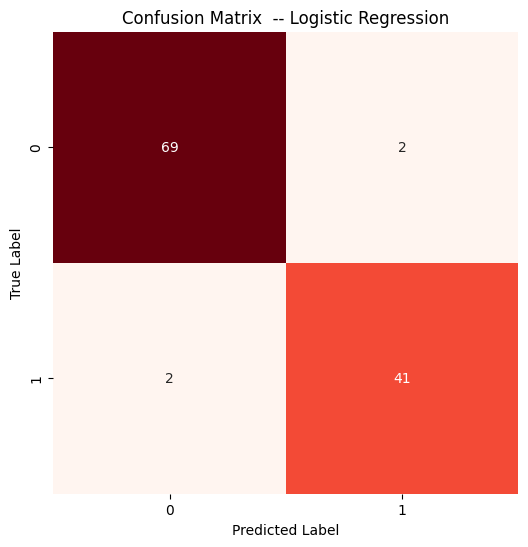

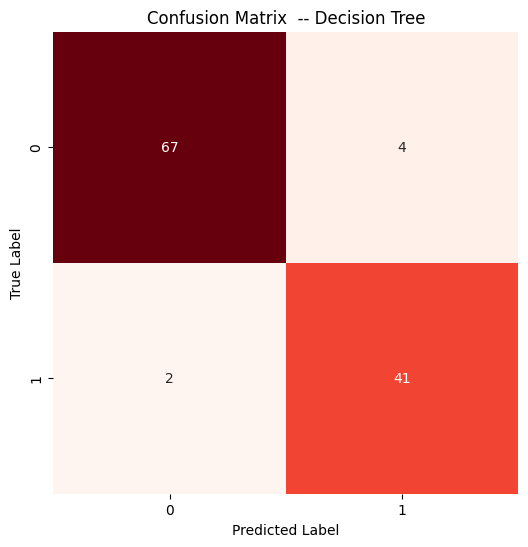

In [173]:
from sklearn.metrics import confusion_matrix
cm_log = confusion_matrix(y_test, y_pred_logistic)
plot_confusion(cm_log, 'Logistic Regression')

cm_tree = confusion_matrix(y_test, y_pred_tree)
plot_confusion(cm_tree, 'Decision Tree')

plt.show()

In reference to the above cell:
* The confusion matrix is plotted for both models. The grid search was performed on "recall" scoring
* As can be seen, the two models have the same recall value 41/(41+2) = 95%
* However, the logistic regression model has better precision 41/(41+2) = 95%, comparing with the desicion tree 41/(41+4)=91%
* The confusion matrix will recommend the logstic regression model in the clinic settings. As there is a good recall rate for the malignant tumours, while logistic regression also has high precision, having less false positives. 

In [174]:
import numpy as np
# Define function to plot Precision, Recall vs, threshold
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    # Get the recall value where precision is above 0.90
    recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
    # Get threshold valie where precision is above 0.90
    threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=10) 
    plt.xlabel("Threshold", fontsize=10)       
    plt.grid(True)                              
    plt.axis([0, 1, 0, 1.1])             

    #plot vertical dash line from precision curve where precision is 0.9
    plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")  

    #plot horizotal dash line from precision curve where precision is 0.9
    plt.plot([-1, threshold_90_precision], [0.9, 0.9], "r:")     

    #plot horisontal line from recall curve where precision is 0.9
    plt.plot([-1, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")

    #plot dot on precision curve where precision is 0.9
    plt.plot([threshold_90_precision], [0.9], "ro")         

    #plot dot on recall curve where precision is 0.9
    plt.plot([threshold_90_precision], [recall_90_precision], "ro")   

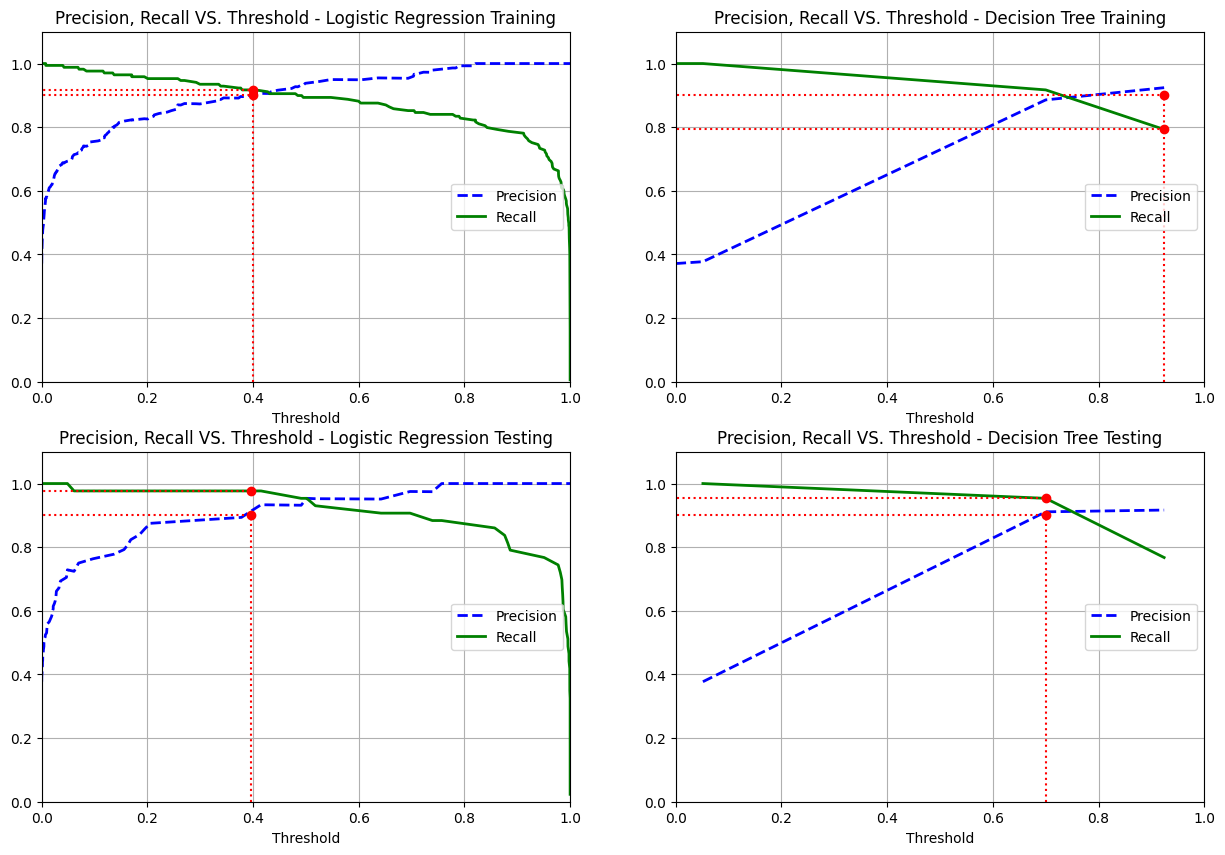

In [175]:
from sklearn.metrics import precision_recall_curve
import numpy as np

plt.figure(figsize=(15, 10)) 
# Calculate precision and recall curve
y_train_prob_log = grid_logistic.predict_proba(X_train)[:, 1]
precisions_train_log, recalls_train_log, thresholds_train_log = precision_recall_curve(y_train, y_train_prob_log)
plt.subplot(2,2,1)
plt.title('Precision, Recall VS. Threshold - Logistic Regression Training')
plot_precision_recall_vs_threshold(precisions_train_log, recalls_train_log, thresholds_train_log)

# Calculate precision and recall curve
y_train_prob_tree = grid_tree.predict_proba(X_train)[:, 1]
precisions_train_tree, recalls_train_tree, thresholds_train_tree = precision_recall_curve(y_train, y_train_prob_tree)
plt.subplot(2,2,2)
plt.title('Precision, Recall VS. Threshold - Decision Tree Training')
plot_precision_recall_vs_threshold(precisions_train_tree, recalls_train_tree, thresholds_train_tree)

# Calculate precision and recall curve
y_test_prob_log = grid_logistic.predict_proba(X_test)[:, 1]
precisions_test_log, recalls_test_log, thresholds_test_log = precision_recall_curve(y_test, y_test_prob_log)
plt.subplot(2,2,3)
plt.title('Precision, Recall VS. Threshold - Logistic Regression Testing')
plot_precision_recall_vs_threshold(precisions_test_log, recalls_test_log, thresholds_test_log)

# Calculate precision and recall curve
y_test_prob_tree = grid_tree.predict_proba(X_test)[:, 1]
precisions_test_tree, recalls_test_tree, thresholds_test_tree = precision_recall_curve(y_test, y_test_prob_tree)
plt.subplot(2,2,4)
plt.title('Precision, Recall VS. Threshold - Decision Tree Testing')
plot_precision_recall_vs_threshold(precisions_test_tree, recalls_test_tree, thresholds_test_tree)


plt.show()

In reference to the cell above:
* The precision and recall are plotted against available thresholds for both training and testing sets. 
* As can be seen, for both models, the precision and recells curves are intersecting close to y = 1, indicating good model performance. 
* The logistic regression model was found to have better performance on the test set than the decision tree (at same recall level, logistic regression has higher precision).
* It is not too easy to tell from the graph above, as the two models have similarly high performance. 
* The below graphs are easier to visualise and help us have a better idea.

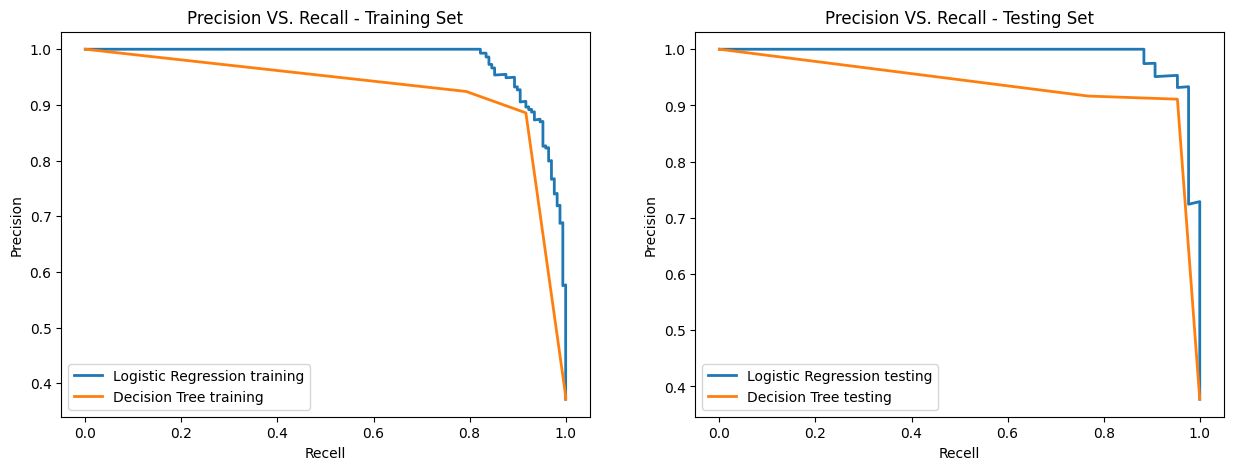

In [176]:
# Plot precision against recall for training & Testing
fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title('Precision VS. Recall - Training Set')
plt.plot(recalls_train_log, precisions_train_log, linewidth=2, label='Logistic Regression training')
plt.plot(recalls_train_tree, precisions_train_tree, linewidth=2, label='Decision Tree training')
plt.xlabel('Recell')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1,2,2)
plt.title('Precision VS. Recall - Testing Set')
plt.plot(recalls_test_log, precisions_test_log, linewidth=2, label='Logistic Regression testing')
plt.plot(recalls_test_tree, precisions_test_tree, linewidth=2, label='Decision Tree testing')
plt.xlabel('Recell')
plt.ylabel('Precision')
plt.legend()

plt.show()

In reference to the above graph:
* Precision and recell are plotted against each other for different thresholds. 
* The closer the curve bends towards (1,1), the better the model performance. 
* As can be seen, for both training and testing set, the logistic regression curve bends more towards (1,1), having better performance than decision tree
* If we draw a vertical line on the graphs, we can see that for the same recall value, the logistic regression model has higher precision.
* Same logic, if we draw a horizontal line, for the same precision value, the logistic regression model has higher recall value. 
* In context of the dataset, we want to be able to identify all the malignant tumours, while not having too many benign tumour falsely identified. The logistic regression model fits the task better.

In [177]:
from sklearn.metrics import auc
def plot_roc(fpr_1, tpr_1, fpr_2, tpr_2, model1, model2):
    plt.plot(fpr_1, tpr_1, linewidth=2, label=model1 + ' train (area = %0.2f)' % auc(fpr_1, tpr_1))
    plt.plot(fpr_2, tpr_2, linewidth=2, label=model2 + ' test (area = %0.2f)' % auc(fpr_2, tpr_2))

    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([-0.1, 1, 0, 1.1])                                    
    plt.xlabel('False Positive Rate (Fall-Out/1-Specificity)', fontsize=12) 
    plt.ylabel('True Positive Rate (Sensitivity/Recall)', fontsize=12) 
    plt.grid(True)  
    plt.legend()

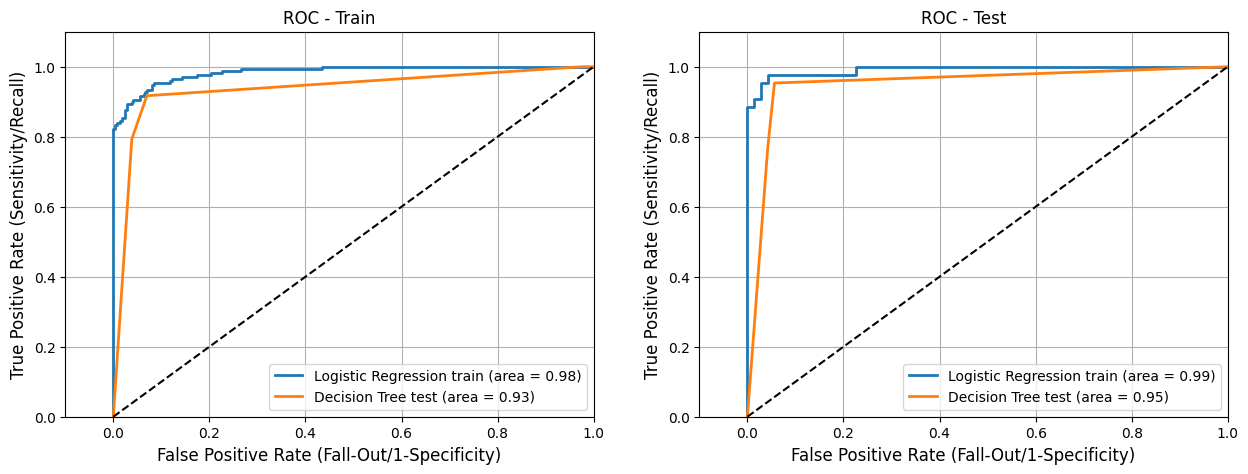

In [178]:
# Plot ROC for training & Testing
from sklearn.metrics import roc_curve

fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
y_train_prob_log = grid_logistic.predict_proba(X_train)[:, 1]
fpr_train_log, tpr_train_log, thresholds_train_log = roc_curve(y_train, y_train_prob_log)

y_train_prob_tree = grid_tree.predict_proba(X_train)[:, 1]
fpr_train_tree, tpr_train_tree, thresholds_train_tree = roc_curve(y_train, y_train_prob_tree)
plt.title('ROC - Train')
plot_roc(fpr_train_log, tpr_train_log, fpr_train_tree, tpr_train_tree, 'Logistic Regression', 'Decision Tree')

plt.subplot(1,2,2)
y_test_prob_log = grid_logistic.predict_proba(X_test)[:, 1]
fpr_test_log, tpr_test_log, thresholds_test_log = roc_curve(y_test, y_test_prob_log)

y_test_prob_tree = grid_tree.predict_proba(X_test)[:, 1]
fpr_test_tree, tpr_test_tree, thresholds_test_tree = roc_curve(y_test, y_test_prob_tree)
plt.title('ROC - Test')
plot_roc(fpr_test_log, tpr_test_log, fpr_test_tree, tpr_test_tree, 'Logistic Regression', 'Decision Tree')

plt.show()

In reference to the cell above:
* The ROC curve is plotted for both boths and both training and teating set
* The AUC is calculated for each ROC curve
* As can be seen, for both training and testing set, the logistic regression model bends more towards (0,1), indicating better performance. This is the same, confirming the above visualisations
* The calculated AUC is also higher for logistic regression for both training and testing set.
* It confirms all the metrics above -- that the logistic regression is better fit for this task -- tumour labelling.

### Task 2: Feature importance from the above models

In [148]:
# Assuming you have already fit the GridSearchCV models
best_logistic = grid_logistic.best_estimator_
best_tree = grid_tree.best_estimator_

# Get coefficients for logistic regression
logistic_coefs = best_logistic.coef_[0]

# Get feature importances for decision tree
tree_importances = best_tree.feature_importances_

In [216]:
feature_names

['radius',
 'texture',
 'smoothness',
 'compactness',
 'concavity',
 'symmetry',
 'fractal']

In [218]:
import numpy as np

feature_names = np.array([i.split('_')[0] for i in features_dropped])

# Sort features by logistic regression coefficients
sorted_idx_logistic = np.argsort(np.abs(logistic_coefs))[::-1]
sorted_features_logistic = feature_names[sorted_idx_logistic]

# Sort features by decision tree importances
sorted_idx_tree = np.argsort(tree_importances)[::-1]
sorted_features_tree = feature_names[sorted_idx_tree]

print("Feature importance ranking for Logistic Regression:")
print(sorted_features_logistic)

print("\nFeature importance ranking for Decision Tree:")
print(sorted_features_tree)


Feature importance ranking for Logistic Regression:
['radius' 'concavity' 'smoothness' 'texture' 'compactness' 'symmetry'
 'fractal']

Feature importance ranking for Decision Tree:
['concavity' 'radius' 'fractal' 'symmetry' 'compactness' 'smoothness'
 'texture']


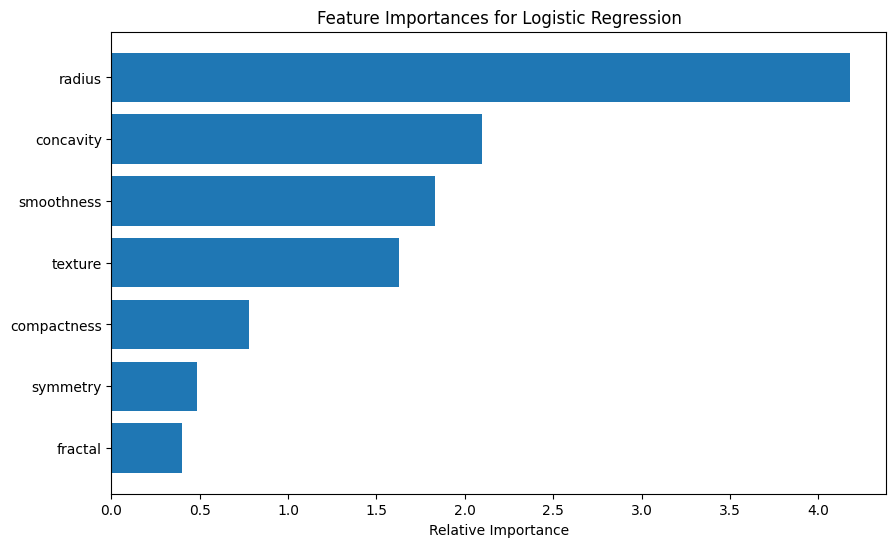

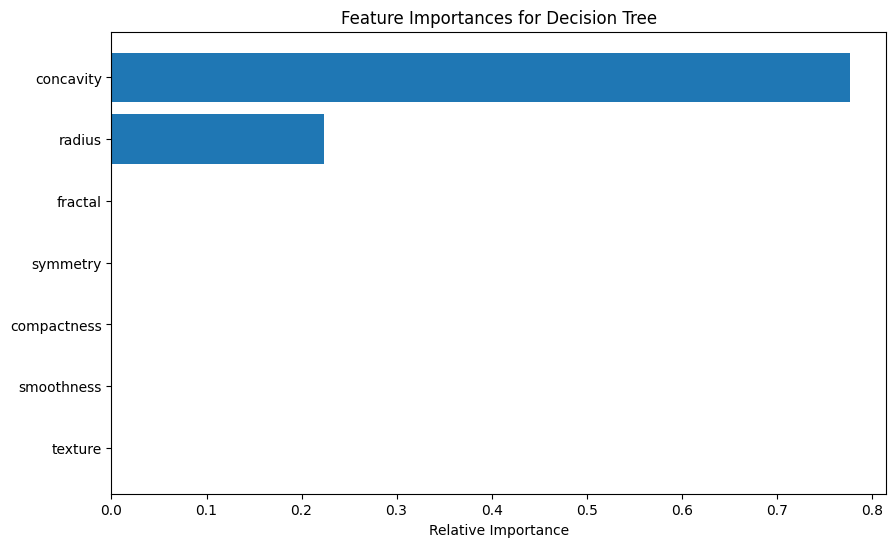

In [219]:
# Function for the feature importance bar plot
def plot_feature_importances(importances, feature_names, model_name):
    indices = np.argsort(importances)
    plt.figure(figsize=(10, 6))
    plt.title(f'Feature Importances for {model_name}')
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

# Plot for Logistic Regression
# Convert coefficients to positive values to denote importance
plot_feature_importances(np.abs(best_logistic.coef_[0]), feature_names, 'Logistic Regression')

# Plot for Decision Tree
plot_feature_importances(best_tree.feature_importances_, feature_names, 'Decision Tree')


### Task 3: PCA implementation

In [220]:
from sklearn.decomposition import PCA

sd_scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit PCA with 2 components
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_scaled)

# Create a DataFrame with the principal components
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

# Concatenate the target
finalDf = pd.concat([principalDf, df_breast[['diagnosis_text']]], axis=1)


In [221]:
# Print explained variance
print('Explained variance by first 2 principal components: {:.2%}'.format(sum(pca.explained_variance_ratio_)))

Explained variance by first 2 principal components: 74.07%


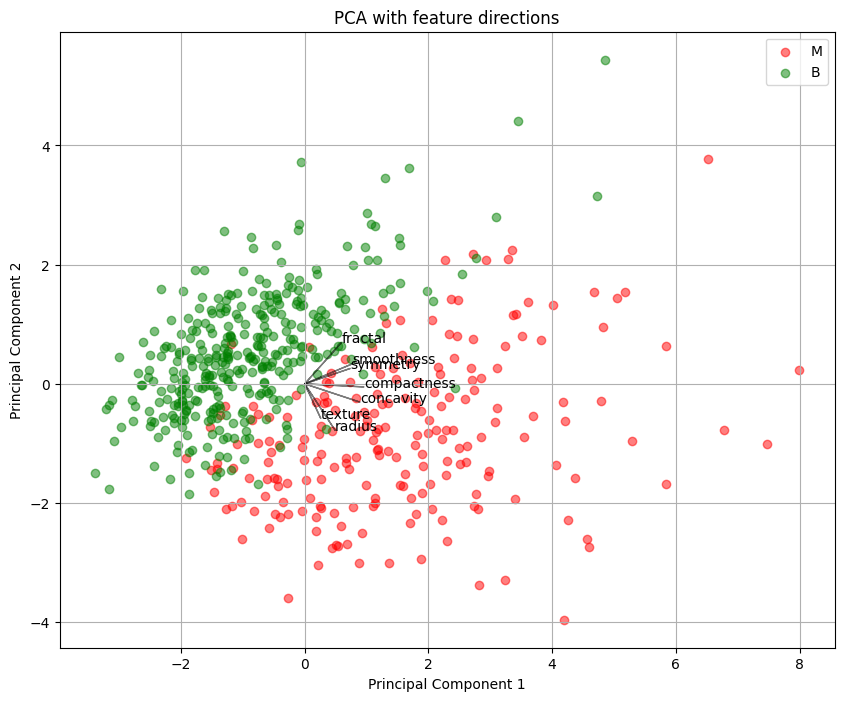

In [223]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot data
# scatter = ax.scatter(principalComponents[:, 0], principalComponents[:, 1], alpha=0.5)

targets = ['M', 'B']
colors = ['r', 'g']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf['diagnosis_text'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1'],
               finalDf.loc[indicesToKeep, 'principal component 2'],
               c=color,
               alpha=0.5)

# Plot arrows for each feature
for i in range(pca.components_.shape[1]):
    plt.arrow(0, 0, pca.components_[0, i]*np.sqrt(pca.explained_variance_[0]), pca.components_[1, i]*np.sqrt(pca.explained_variance_[1]), color='black',alpha=0.5)
    plt.text(pca.components_[0, i]*np.sqrt(pca.explained_variance_[0]), pca.components_[1, i]*np.sqrt(pca.explained_variance_[1]), feature_names[i])
    

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA with feature directions')
plt.legend(targets)
plt.grid()
plt.show()


In [226]:
from sklearn.metrics import roc_auc_score
# Fit PCA, specifying the amount of variance to retain
pca_95 = PCA(n_components=0.95)
principalComponents_95 = pca_95.fit_transform(X_scaled)

# Print the number of components
print("Number of components to retain 95% variance: ", pca_95.n_components_)

# Split the transformed data
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(principalComponents_95, y, test_size=0.2, random_state=42)

param_grid = [
    {
        'solver': ['newton-cg', 'lbfgs', 'sag'], 
        'penalty': ['l2'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'max_iter': [300],
        'random_state':[42]
    },
    {
        'solver': ['liblinear', 'saga'], 
        'penalty': ['l1', 'l2'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'max_iter': [300],
        'random_state':[42]
    },
    {
        'solver': ['saga'], 
        'penalty': ['elasticnet'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],  
        'max_iter': [300],
        'random_state':[42]
    }
]

# Initiate Logistic Regression model
logistic_pca = LogisticRegression()

# Grid search
clf_pca = GridSearchCV(logistic_pca, param_grid, cv=5, scoring='recall')

# Fit model with the PCA-transformed data
clf_pca.fit(X_train_pca, y_train_pca)

# Report the best combination of hyperparameters and the corresponding score
print("Best hyperparameters:", grid_logistic.best_params_)
print("Best score:", grid_logistic.best_score_)

# Predict on test data
y_pred_pca = clf_pca.predict(X_test_pca)

# Print classification report
print(classification_report(y_test_pca, y_pred_pca))

# Print AUC score
auc_score_pca = roc_auc_score(y_test_pca, clf_pca.predict_proba(X_test_pca)[:, 1])
print("AUC Score with PCA features: ", auc_score_pca)

# Print confusion matrix
print("\nLogistic Regression Confusion Matrix:\n", confusion_matrix(y_test, y_pred_logistic))



Number of components to retain 95% variance:  5
Best hyperparameters: {'C': 100, 'max_iter': 300, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg'}
Best score: 0.8877005347593583
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        71
           1       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

AUC Score with PCA features:  0.9937766131673764

Logistic Regression Confusion Matrix:
 [[69  2]
 [ 2 41]]


# Section 2: A clustering analysis on airlines safety records <br>

# Section 3: A clustering analysis on the USArrests data <br>